In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import torch
from gpytorch import kernels

from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%matplotlib notebook

In [2]:
data = np.loadtxt("/home/max/Software/potential-bassoon/data/data.txt")

In [3]:
np.random.shuffle(data)
# 20k seems to be the limit for OOM
# sub_data = data[:100000]
sub_data = data

In [24]:
# norm everything
X = sub_data
print(X.shape, X.max(), X.min(), X.mean())
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X.shape, X.max(), X.min(), X.mean())

# only use spatial points for kernel
if True:
    torch_subdata = torch.tensor(X[:, [0, 1, 2]])
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_subdata) 
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:
    z_vals = RBF(1.).__call__(X[:, [0, 1, 2]])[0]


X = np.array([*X.T, z_vals]).T
print(X.shape, X.max(), X.min(), X.mean())

(694764, 7) 38340.40625 -7516.96337890625 442.51165253555394
(694764, 7) 217.38596134258458 -4.197077780281196 1.075219829951071e-16
(694764, 8) 217.38596134258458 -4.197077780281196 0.2599302097116237


1 -11.91067462973206
2 -6.550913480598229
3 -5.411757094855483
4 -4.393595481645407
5 -4.300611338771785
6 -3.3646641097597234
7 -3.341090420282354
8 -2.765766671015237
9 -2.1259537261117405
10 -3.0322686808966273
11 -2.312786983347134
12 -2.092712994699739
13 -1.9323831707579822
14 -1.543977915608442
15 -1.5364975158955534
16 -1.5067903903041358
17 -1.2341296267339854
18 -1.1335374254148025
19 -0.8368329767988778
20 -1.0624042086599528
21 -0.8932890788963014
22 -0.5852608971740592
23 -0.6589543139491437
24 -0.23054741417312194


<IPython.core.display.Javascript object>


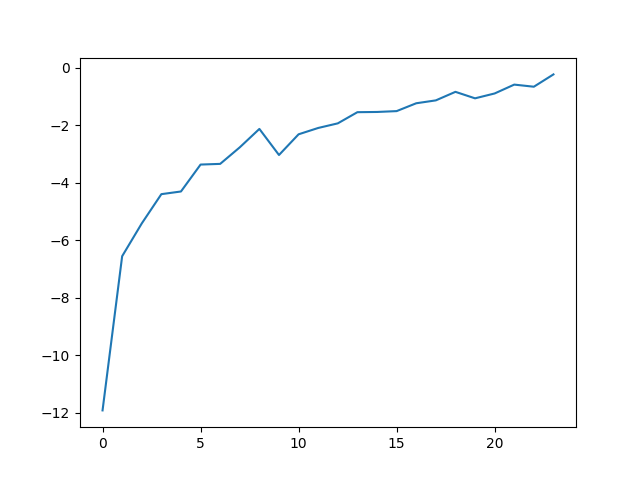

In [19]:
elbos = []
for i in range(1, 25):
    model = GaussianMixture(n_components=i)
    model.fit(X)
    elbos.append(model.lower_bound_)
    print(i, model.lower_bound_)
    
plt.plot(elbos)
plt.show()    

In [36]:
# model = BayesianGaussianMixture(n_components=20)
model = GaussianMixture(n_components=12)
model.fit(X)
pred_y1 = model.predict(X)

# w_arr = np.array(model.weight_concentration_)

print((w_arr > 1.).sum())

values, counts = np.unique(pred_y1, return_counts=True)
values = list(values)
print(values, counts)

plot_dat = np.array([sub_data.T[0], sub_data.T[1], sub_data.T[2], pred_y1]).T[:10000]

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_dat.T[3], marker=".", cmap="plasma")
# plt.show()



clusters = []
labels = []
elbo_rat = []

for val in values.copy():
    plot_dat = sub_data[pred_y1 == val]
    plot_y = pred_y1[pred_y1 == val]
    
    model = GaussianMixture(n_components=1)
    model.fit(plot_dat)
    m1 = model.lower_bound_
    
    model = GaussianMixture(n_components=2)
    model.fit(plot_dat)
    m2 = model.lower_bound_

    print(m1 / m2, m1, m2)
    elbo_rat.append(m1 / m2)
    
    if (m1 / m2) < 1.075:
        clusters.append(plot_dat)
        labels.append(plot_y)
        
#         fig = plt.figure(figsize=(8, 8))
#         ax = fig.add_subplot(projection='3d')
#         ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_y, marker=".", cmap="plasma")
#         plt.show()

    else:
        
        plot_pred_y = model.predict(plot_dat)
        new_label = len(values)
        
        clusters.append(plot_dat[plot_pred_y==0])
        labels.append(plot_y[plot_pred_y==0])
        
        clusters.append(plot_dat[plot_pred_y==1])
        plot_y[plot_pred_y==1] = new_label
        labels.append(plot_y[plot_pred_y==1])
        values.append(new_label)
        
#         fig = plt.figure(figsize=(8, 8))
#         ax = fig.add_subplot(projection='3d')
#         ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_pred_y, marker=".", cmap="plasma")
#         plt.show()

clusters = np.array(clusters)
labels = np.array(labels)

39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [ 76084 123955  69754  54851  39013  39652  46778  55511  91913  35670
  11801  49782]
1.0259413791214478 -25.520702092730733 -24.87539991279528
1.0548286248020498 -19.68473219546817 -18.66154532842928
1.066415022088014 -20.245402443101796 -18.98454356303215
1.0129467417229858 -29.419982553690314 -29.043957931734877
1.0086382265492448 -30.256138527249504 -29.997017494331807
1.00766349532826 -34.532496327283646 -34.26986934366837
1.0416368669864926 -26.16640962525598 -25.120471878992443
1.064046610349315 -22.062821743391655 -20.73482639651347
1.056924070923579 -22.746785975307517 -21.521684103031678
1.105510618489474 -20.86328529824082 -18.87208042085348
1.0163964917025492 -39.19501258650292 -38.56271927980388
1.0215549662473606 -27.5715539881504 -26.989789976190263


<ipython-input-36-c5231b5ff89e>:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clusters = np.array(clusters)
<ipython-input-36-c5231b5ff89e>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels = np.array(labels)


(76084, 7) (76084,)


<IPython.core.display.Javascript object>


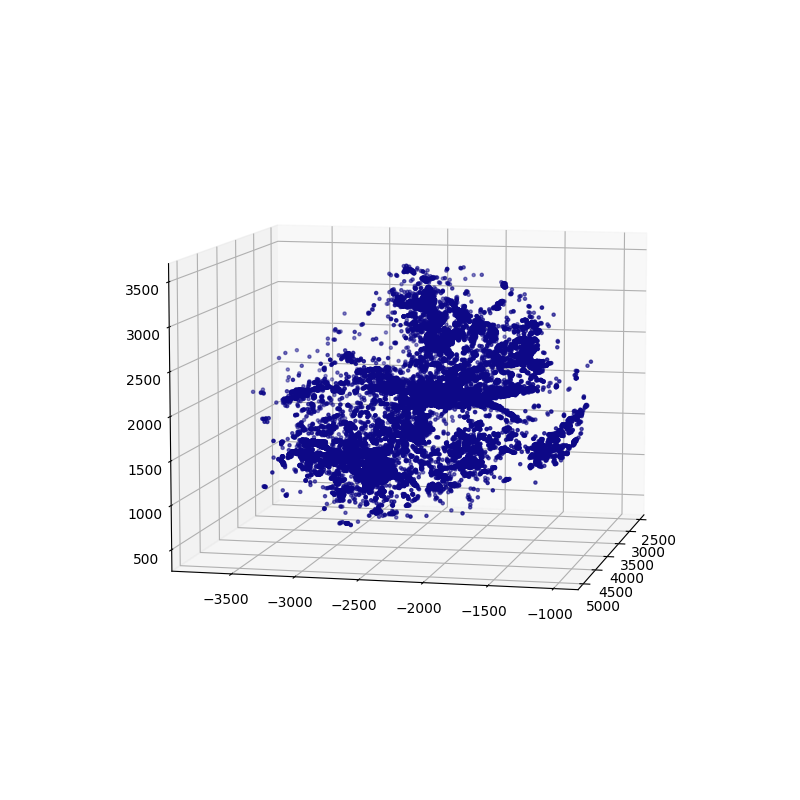

(123955, 7) (123955,)


<IPython.core.display.Javascript object>


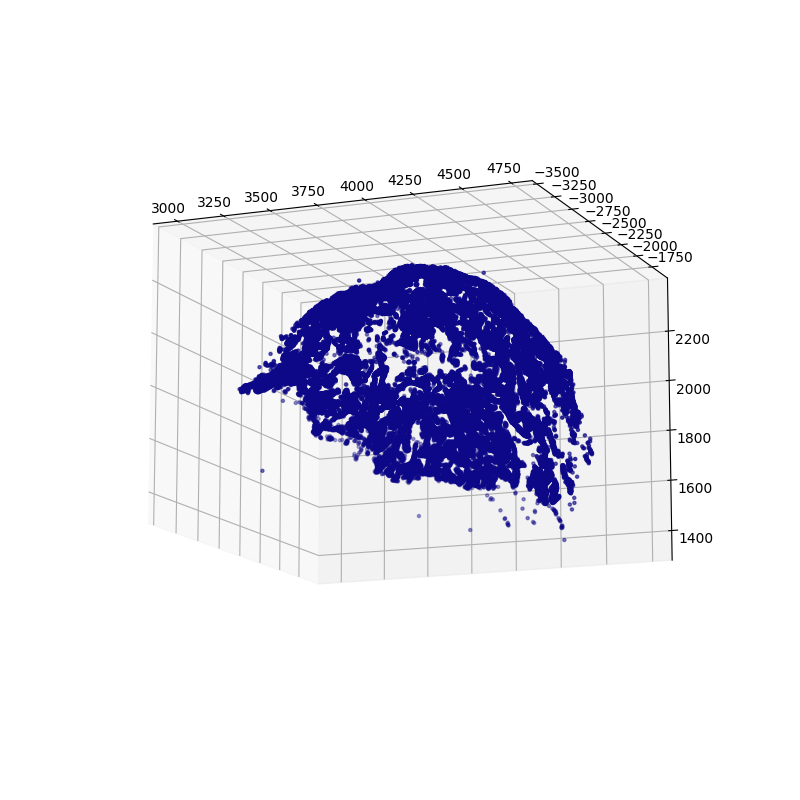

(69754, 7) (69754,)


<IPython.core.display.Javascript object>


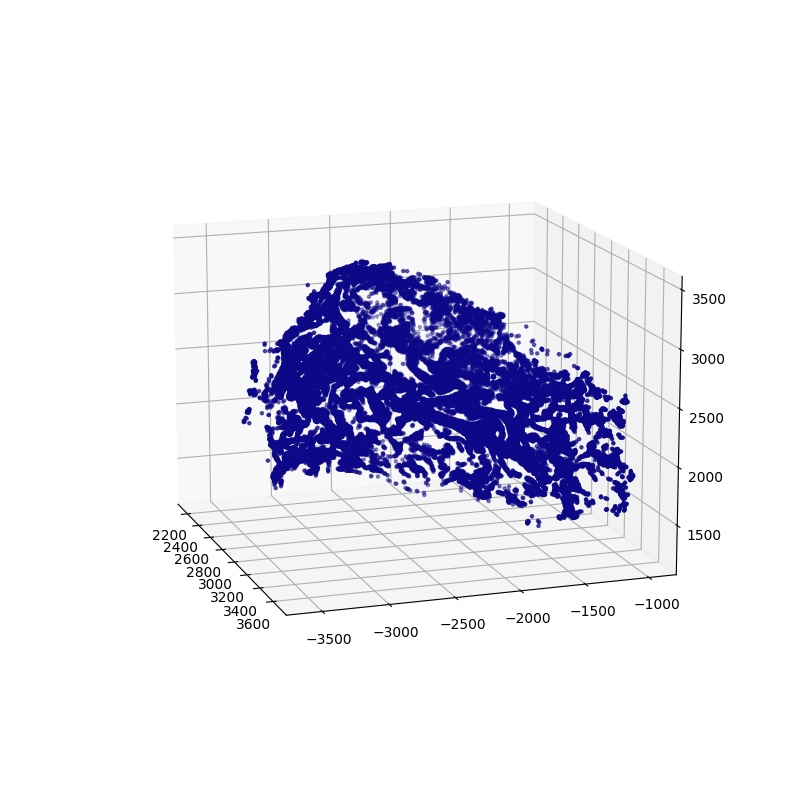

(54851, 7) (54851,)


<IPython.core.display.Javascript object>


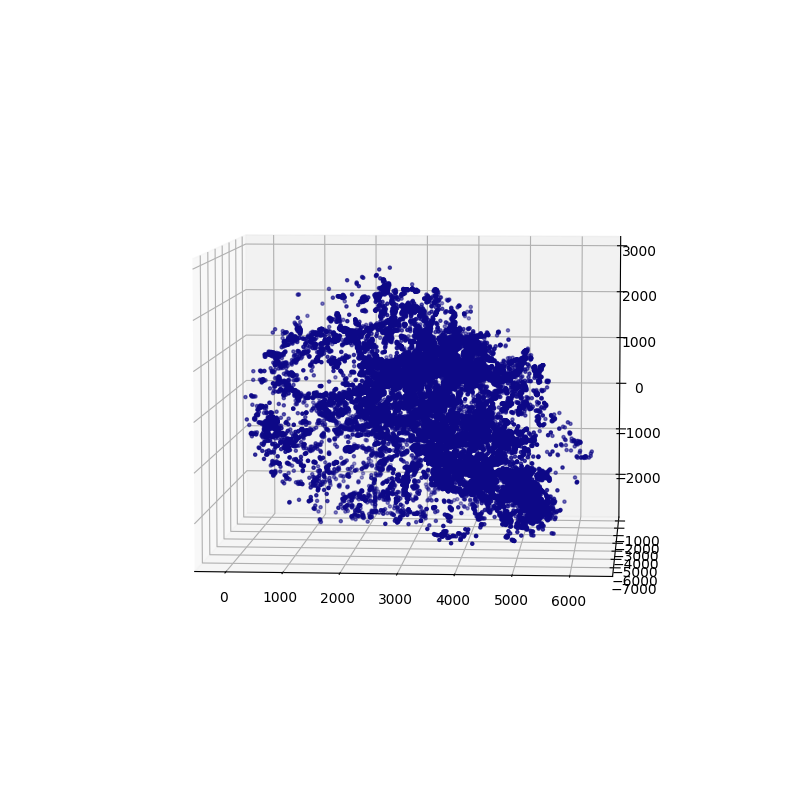

(39013, 7) (39013,)


<IPython.core.display.Javascript object>


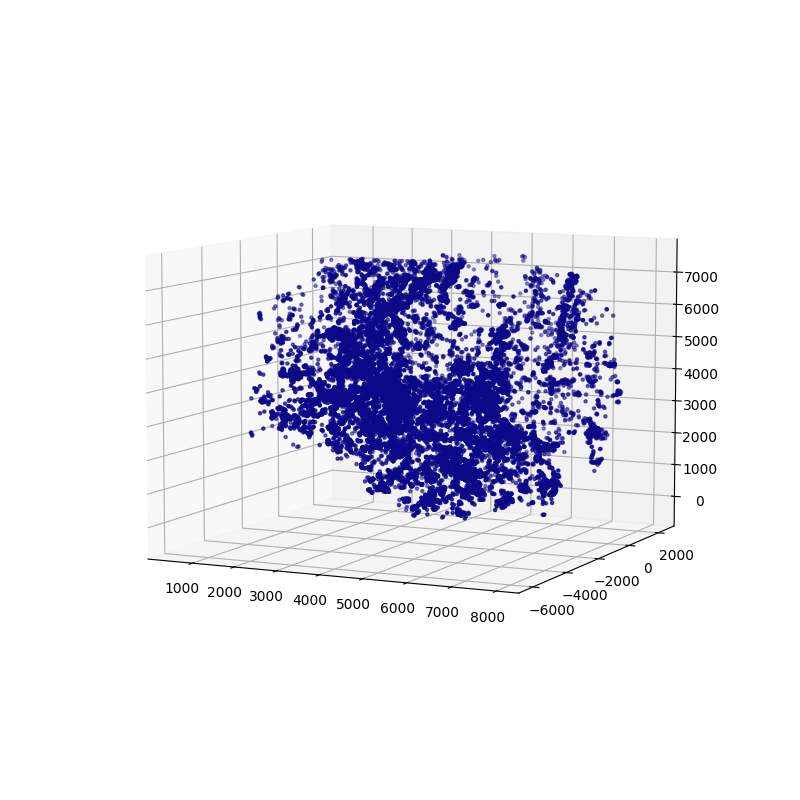

(39652, 7) (39652,)


<IPython.core.display.Javascript object>


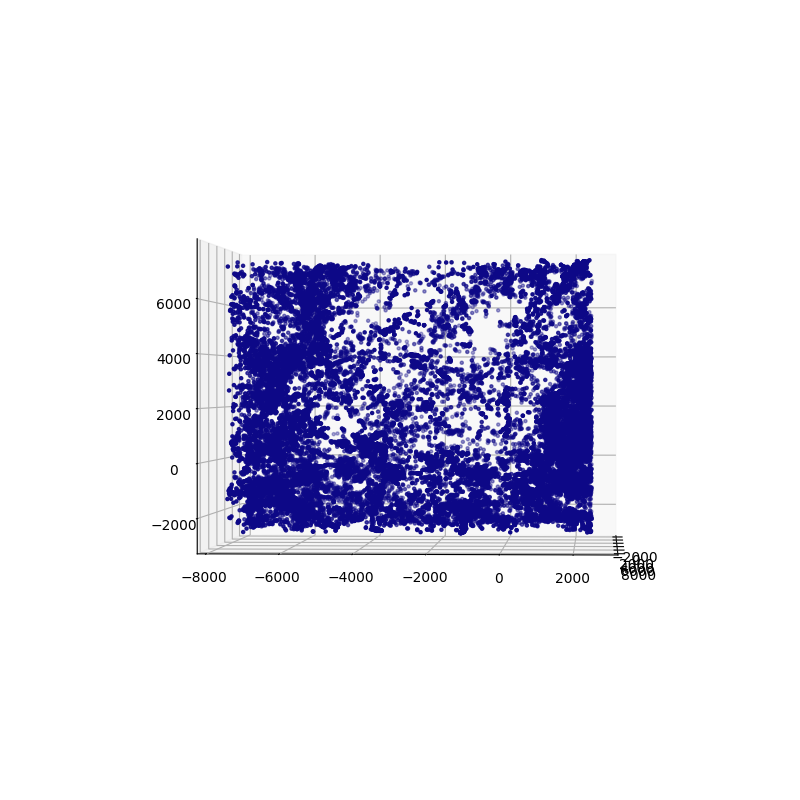

(46778, 7) (46778,)


<IPython.core.display.Javascript object>


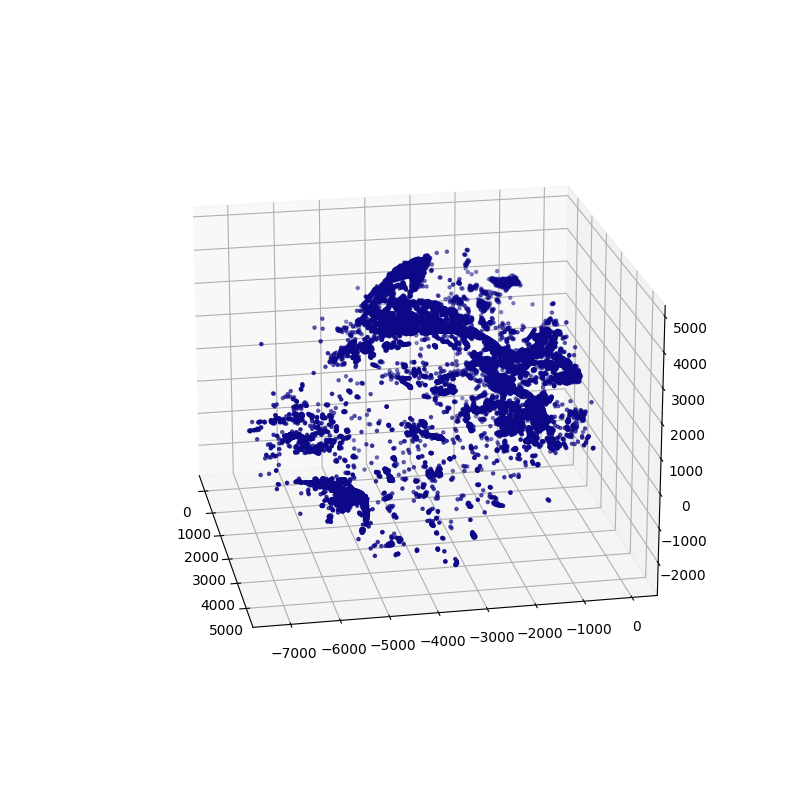

(55511, 7) (55511,)


<IPython.core.display.Javascript object>


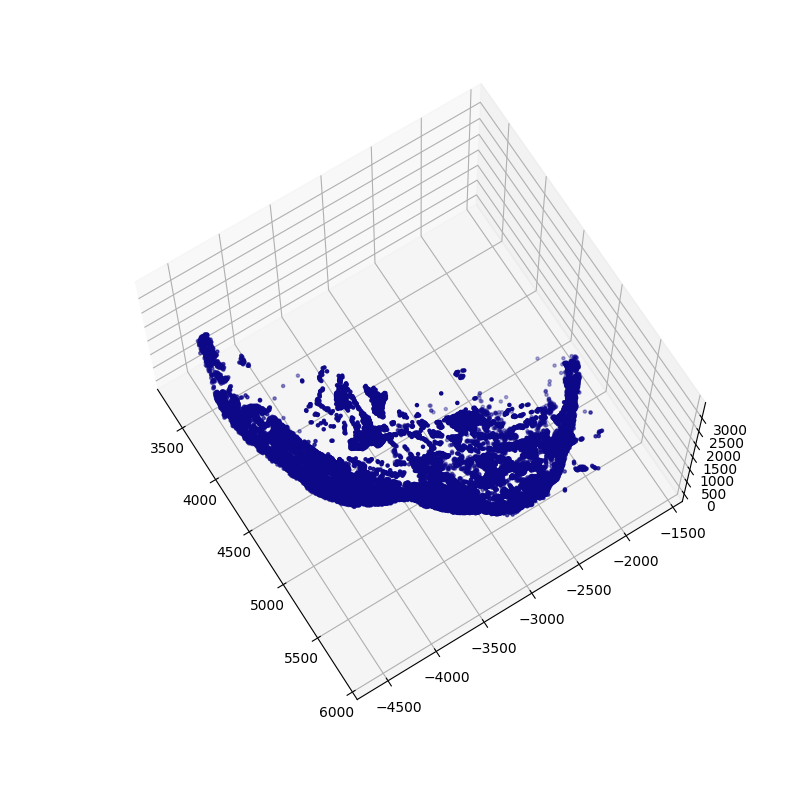

(91913, 7) (91913,)


<IPython.core.display.Javascript object>


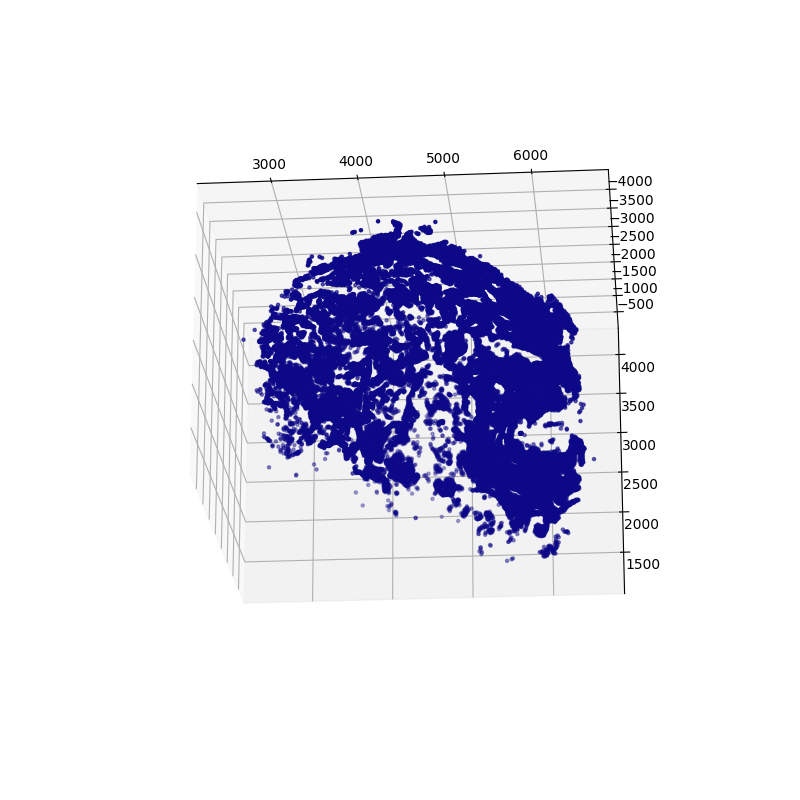

(27760, 7) (27760,)


<IPython.core.display.Javascript object>


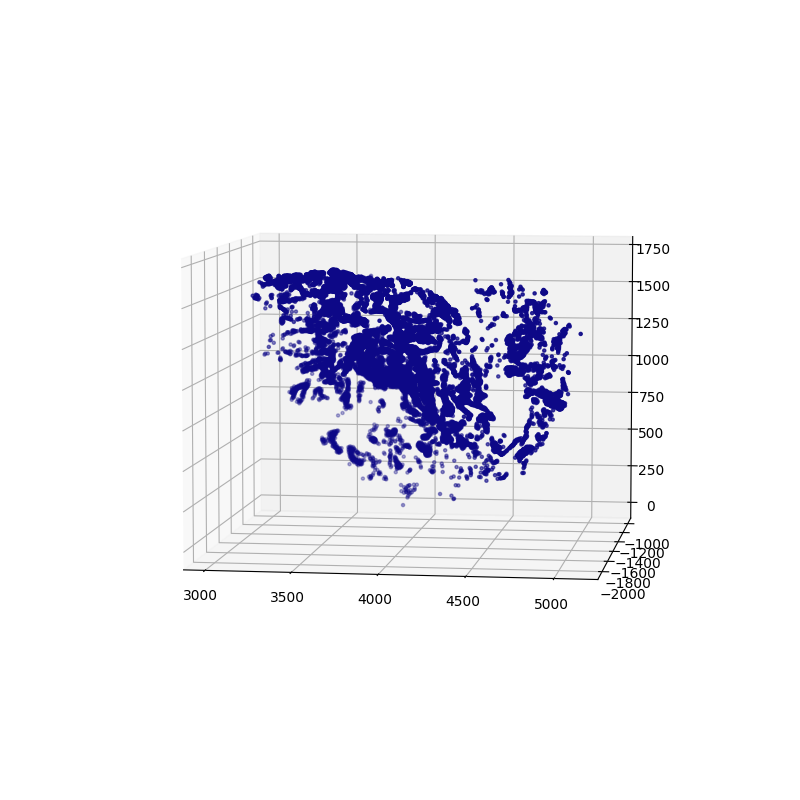

(7910, 7) (7910,)


<IPython.core.display.Javascript object>


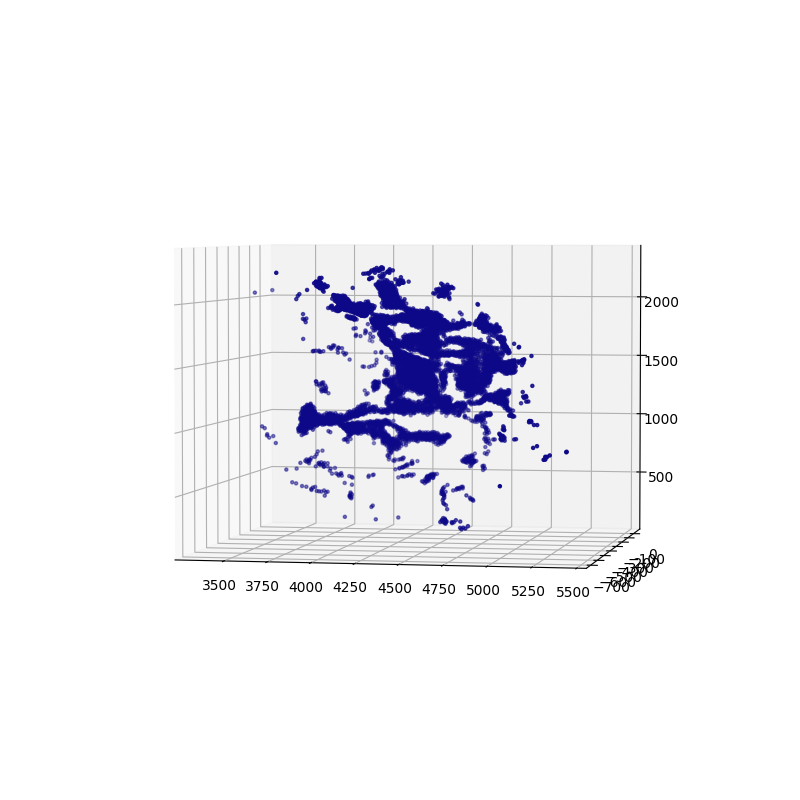

(11801, 7) (11801,)


<IPython.core.display.Javascript object>


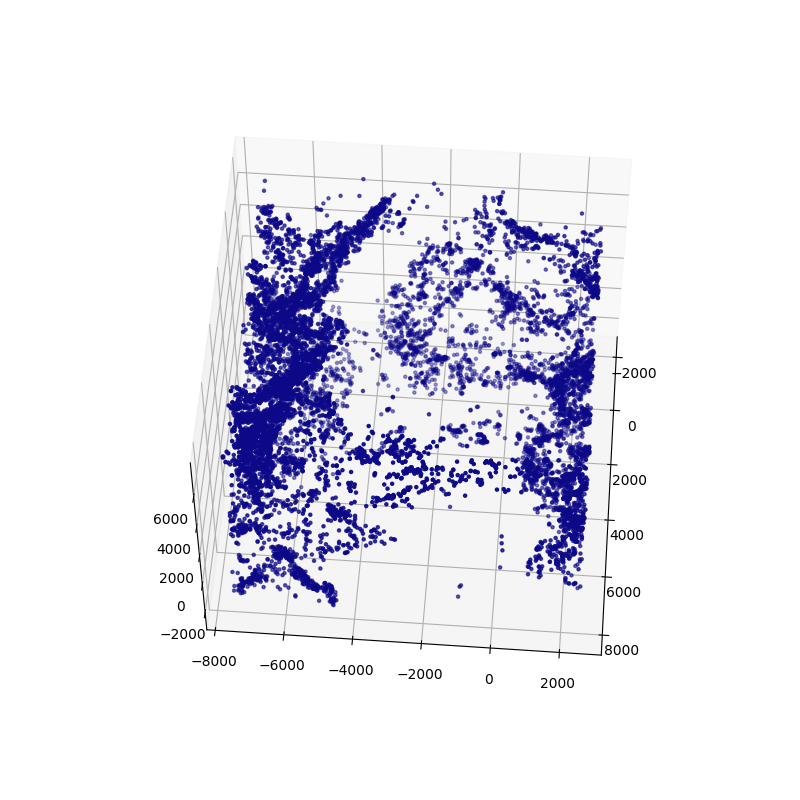

(49782, 7) (49782,)


<IPython.core.display.Javascript object>


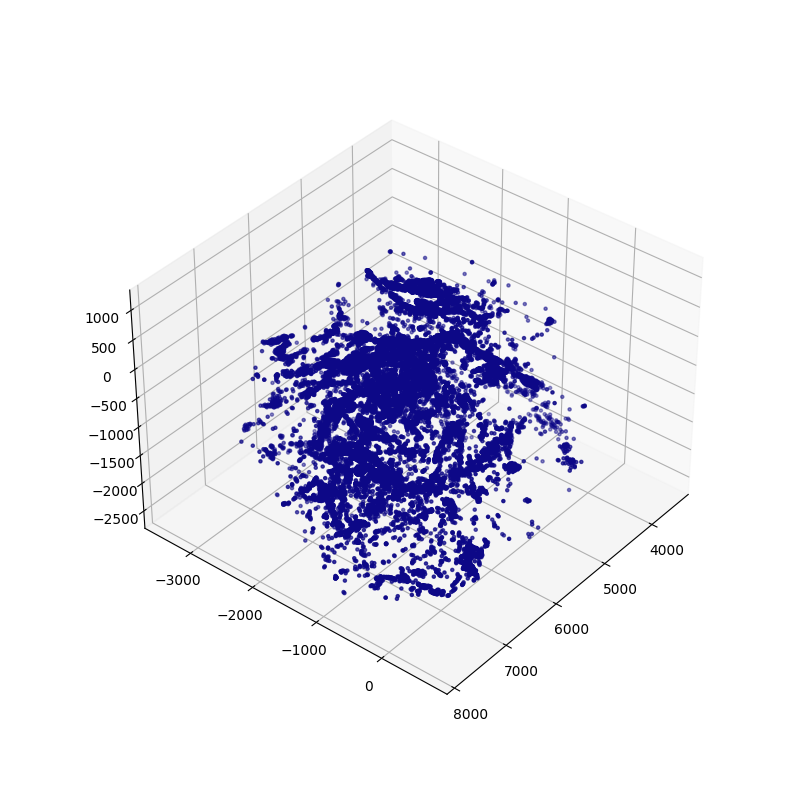

In [37]:
for ind, clust in enumerate(clusters):
    print(clust.shape, labels[ind].shape)
    
    if ind == 0:
        all_clusters = np.array(clust)
        all_labs = np.array(labels[ind])
    else:
        all_clusters = np.concatenate([all_clusters, clust])
        all_labs = np.concatenate([all_labs, labels[ind]])
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(clust.T[0], clust.T[1], clust.T[2], c=labels[ind], marker=".", cmap="plasma")
    plt.show()



<IPython.core.display.Javascript object>


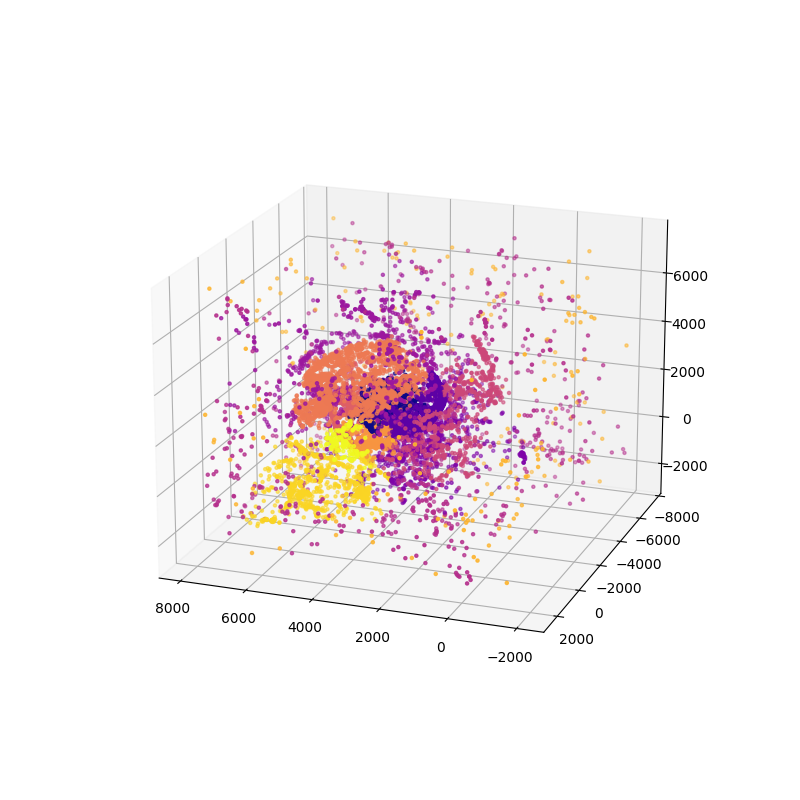

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters[::50]
plot_y = all_labs[::50]

ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

In [41]:
# all_clusters
# # all_labs
# print(all_clusters.shape, all_labs.shape)
# np.savetxt('all_clusters.txt', all_clusters)
# np.savetxt('all_labs.txt', all_labs)

(694764, 7) (694764,)


In [96]:
all_clusters = np.loadtxt('all_clusters.txt')
all_labs = np.loadtxt('all_labs.txt')
print(all_clusters.shape, all_labs.shape)

(694764, 7) (694764,)


In [119]:
# find each group average nn-distance

classes = np.unique(all_labs)
print(f"Classes {classes}")
mean_dist = []

for c in classes:

    clust = all_clusters[all_labs==c]
    dists = []
    # data was shuffled at the very beginning
    for i in range(300):
        point = clust[i]
        dist_to_all = np.sqrt(((clust[:,[0, 1, 2]] - point[[0, 1, 2]]) ** 2).sum(1))
        dist_to_all = np.sort(dist_to_all)
        dists.append(dist_to_all[1])

    dists = np.array(dists)
    mean_dist.append(dists.mean())
    
mean_dist = np.array(mean_dist)
print(mean_dist)

Classes [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[ 4.17634076  2.93286717  6.41091949 18.0497041  21.22391208 47.27651545
 13.09520701  7.78113887 10.04904564  5.46533621 79.58802297  8.91842193
 11.75562565]


In [126]:
# set all labels to -1 for point with different label in 2 * avg_nn-distance 
# (3 times? - no, every point touched got changed)

all_labs_cp = all_labs.copy()
point_steps=50

for i in range(0, all_clusters.shape[0], point_steps):
    if i%25000 == 0:
        print(f"Current: {i/all_clusters.shape[0]:0.3f} [{i} / {all_clusters.shape[0]}]")
#     if i > 10000:
#         break
    
    point = all_clusters[i]
    label = all_labs_cp[i]
    clusters = np.delete(all_clusters, i, axis=0)

    dist_to_all = ((clusters[:,[0, 1, 2]] - point[[0, 1, 2]]) ** 2).sum(1) 
    dist_to_all = dist_to_all - 2. * mean_dist[int(label)]
    
    prox_points = clusters[dist_to_all <= 0.]
    prox_labs = clusters[dist_to_all <= 0.]

    sum_diff_labs = (prox_labs != label).sum()
    sum_neg_labs = (prox_labs == -1.).sum()

    # only set -1 if actual different predicted value in nn
    if (sum_diff_labs - sum_neg_labs) >= 1.:
#         print(sum_diff_labs, sum_neg_labs)
#         print(i, (prox_labs != label).sum())
        all_labs_cp[i] = -1000.
    

classes, counts = np.unique(all_labs_cp, return_counts=True)
print(f"Classes {classes}, counts {counts}")
quota = counts[0] / (all_clusters.shape[0] / point_steps)
print(f"ratio labels cleaned per point studied {quota:0.2f}")

Current: 0.000 [0 / 694764]
Current: 0.036 [25000 / 694764]
Current: 0.072 [50000 / 694764]
Current: 0.108 [75000 / 694764]
Current: 0.144 [100000 / 694764]
Current: 0.180 [125000 / 694764]
Current: 0.216 [150000 / 694764]
Current: 0.252 [175000 / 694764]
Current: 0.288 [200000 / 694764]
Current: 0.324 [225000 / 694764]
Current: 0.360 [250000 / 694764]
Current: 0.396 [275000 / 694764]
Current: 0.432 [300000 / 694764]
Current: 0.468 [325000 / 694764]
Current: 0.504 [350000 / 694764]
Current: 0.540 [375000 / 694764]
Current: 0.576 [400000 / 694764]
Current: 0.612 [425000 / 694764]
Current: 0.648 [450000 / 694764]
Current: 0.684 [475000 / 694764]
Current: 0.720 [500000 / 694764]
Current: 0.756 [525000 / 694764]
Current: 0.792 [550000 / 694764]
Current: 0.828 [575000 / 694764]
Current: 0.864 [600000 / 694764]
Current: 0.900 [625000 / 694764]
Current: 0.936 [650000 / 694764]
Current: 0.972 [675000 / 694764]
Classes [-1000.     0.     1.     2.     3.     4.     5.     6.     7.     8.
     

In [128]:
all_labs_cp[all_labs_cp==-1000.] = -1.

<IPython.core.display.Javascript object>


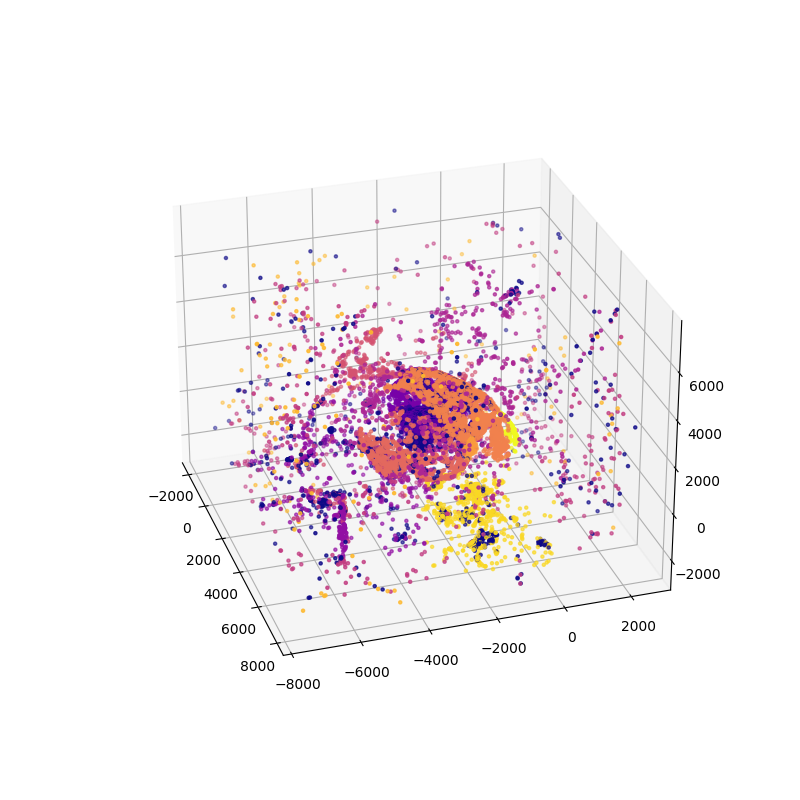

In [129]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters_cp[::point_steps]
plot_y = all_labs_cp[::point_steps]

ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

In [130]:
np.savetxt('all_labs_cleaned.txt', all_labs_cp)